# **CSS 490 Team 1**
**Kylun Robbins**

# **Imports**

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()

import pylab
from statsmodels.stats import proportion
import sklearn.preprocessing as preprocessing

# **Dataset**

In [102]:
# Url to data hosted on github
# Original data source: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016?select=master.csv
data_url = 'https://raw.githubusercontent.com/KylunR/SuicideRateDataAnalysis/master/data.csv'


# Columns of data to read into
features = ["Country", "Year", "Sex", "Age", "Suicides_No", "Population", "Suicides/100K", 
            "Country_Year", "HDI", "GDP", "GDP_Per_Capita", "Generation"]


# Read data into features
data = pd.read_csv(data_url, names=features, sep=',', engine='python', na_values='?', skiprows=1)

# For testing, view table
#data.head()
data.tail()

,Country,Year,Sex,Age,Suicides_No,Population,Suicides/100K,Country_Year,HDI,GDP,GDP_Per_Capita,Generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


# **Data Visualization**

**Total Number of Suicides Over Time**

Text(0.5, 1.0, 'Number of Suicides Per Year')

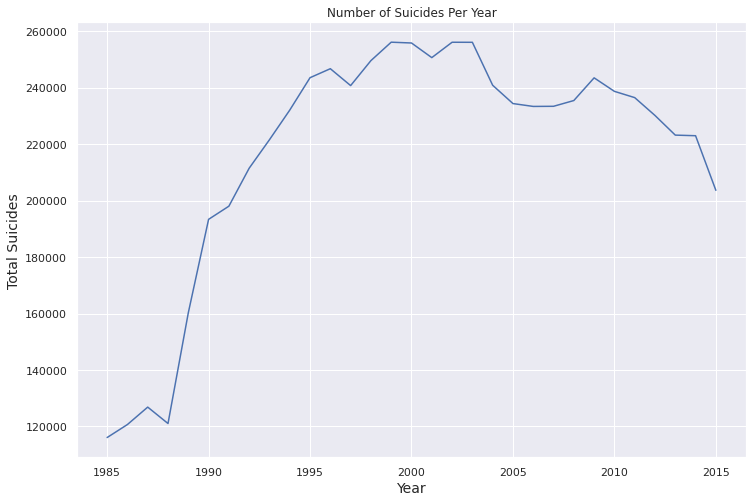

In [103]:
year = data.groupby('Year').Year.unique()

plt.figure(figsize=(12, 8))

total_per_year = pd.DataFrame(data.groupby('Year').Suicides_No.sum())

plt.plot(year.index[0:31], total_per_year[0:31])
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Suicides', fontsize=14)
plt.title('Number of Suicides Per Year')

Total number of suicides over time is not the best model for understanding suicide because as population increases, it would be expected that number of suicides increases.

**Suicide Rates (/100K) Over Time**

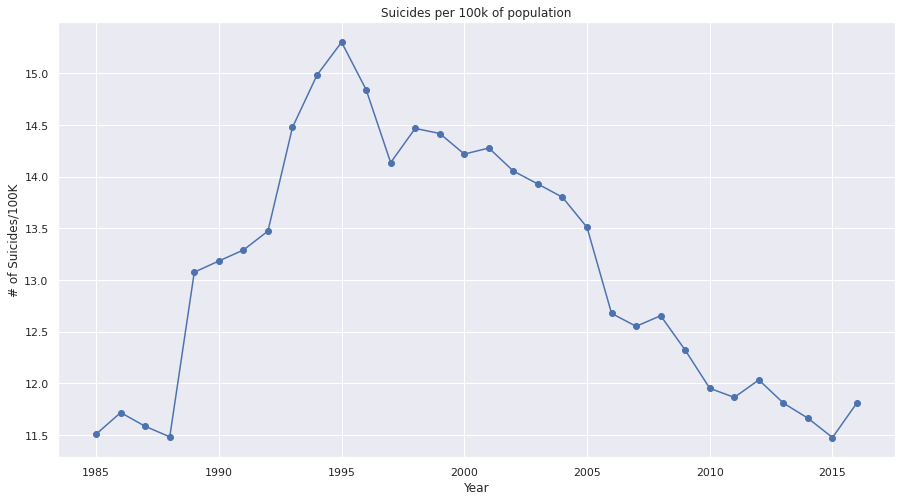

In [104]:
glo = data.groupby(['Year']).agg({'Suicides_No' : 'sum','Population':'sum',}).reset_index()
glo['Suicides_Per_Capita'] = glo.Suicides_No / glo.Population * 100000
plt.figure(figsize = (15,8))
_ = plt.plot(glo.Year,glo.Suicides_Per_Capita,'-o')
_ = plt.title('Suicides per 100k of population')
_ = plt.xlabel('Year')
_ = plt.ylabel('# of Suicides/100K')

This is a better visualization of number of suicides over time because it takes into consideration the number of suicides per a segment of population.  This prevents a great increase or decrease in population from affecting the trend.

**Suicide Rate for Age Groups**

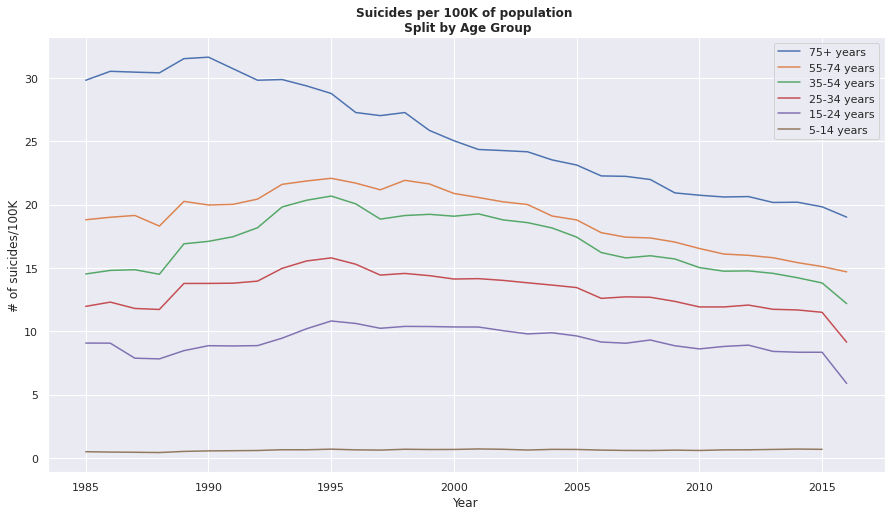

In [105]:
age = data.groupby(['Year','Age']).agg({'Population' : 'sum','Suicides_No': 'sum'}).reset_index()
age['Suicides_Per_Capita'] = age.Suicides_No / age.Population * 100000


def age_plot(agegroup):
    data1 = age.loc[age['Age'] == agegroup,['Year','Suicides_Per_Capita']]
    _ = plt.plot(data1['Year'],data1['Suicides_Per_Capita'])

agegroups = [ '75+ years', '55-74 years', '35-54 years', '25-34 years', '15-24 years', '5-14 years']

plt.figure(figsize = (15,8))

for i in agegroups:
    age_plot(i)
_ = plt.legend(agegroups)
_ = plt.title('Suicides per 100K of population \n Split by Age Group', fontweight='bold')
_ = plt.xlabel('Year')
_ = plt.ylabel('# of suicides/100K')

This graph shows that suicide rate is higher amongst older ages and each age group decreases in suicide rate.  

I found this data interesting, I would like to further research how this has changed in the recent years.

**Suicide Rate for Male vs. Female**

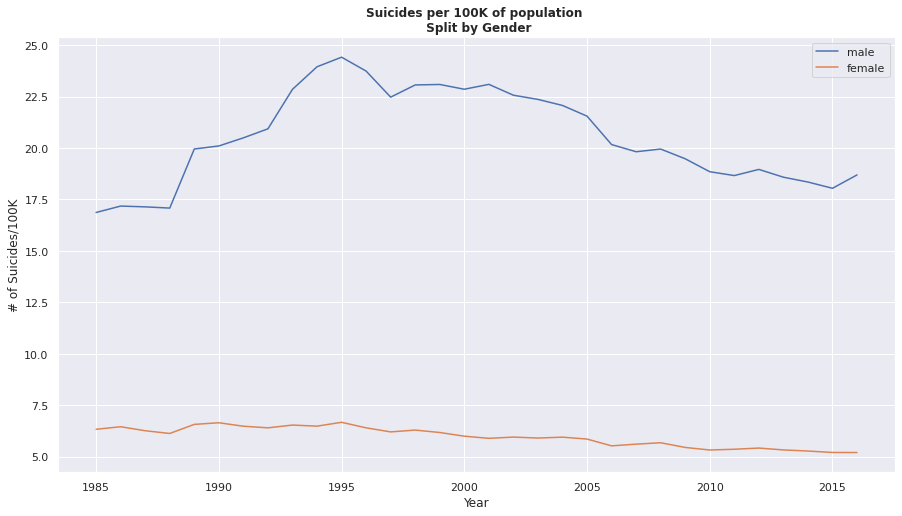

In [106]:
# split by men and woman
gender = data.groupby(['Year','Sex']).agg({'Suicides_No' : 'sum','Population' : 'sum'}).reset_index()
gender['Suicides_Per_Capita'] = gender.Suicides_No / gender.Population * 100000

def gender_plot(sex): 
    data = gender.loc[gender['Sex'] == sex,['Year','Suicides_Per_Capita']]
    plt.plot(data['Year'],data['Suicides_Per_Capita'])

plt.figure(figsize = (15,8))
for i in ('male','female'):
    gender_plot(i)

_ = plt.legend(('male','female'))
_ = plt.title('Suicides per 100K of population \n Split by Gender', fontweight='bold')
_ = plt.xlabel('Year')
_ = plt.ylabel('# of Suicides/100K')

This graph shows the suicide is much more prominent for the male population when compared to the female population.

Male suicide rate appears to rise and fall many times over this time period with it ending on a rise.  While female suicide rate has mostly stayed the same and has even slightly decreased over the time period.

# **Data Normalization**

In [107]:
# Data normalization

# Drop Country, Year, Country_Year, HDI
data.drop(['Country', 'Year', 'Country_Year', 'HDI'], axis=1, inplace=True)

# Replace Generation with int values
data.Generation.replace(['Boomers', 'Generation X', 'Generation Z', 'G.I. Generation', 'Millenials', 'Silent'], 
                        ['0', '1', '2', '3', '4', '5'], inplace=True)

# Replace male with 0, female with 1
data.Sex.replace(['male', 'female'], ['0', '1'], inplace=True)

# Remove commas from gdp value
data['GDP'] = data['GDP'].str.replace(',','')

# Used for finding averages of age range
def means(arr):
    return str(np.array(arr).mean())

# Replace age ranges with averages
data.Age.replace(['15-24 years', '25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years'], 
                 [means([15, 24]), means([25, 34]), means([35, 54]), 
                  means([5, 14]), means([55, 74]), means([75])], inplace=True)

# Converting string values to numeric
pd.to_numeric(data['Generation']);
pd.to_numeric(data['Sex']);
pd.to_numeric(data['GDP']);

"""
def data_transform(df):
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data
data = data_transform(data)
"""

'\ndef data_transform(df):\n    binary_data = pd.get_dummies(df)\n    feature_cols = binary_data[binary_data.columns[:-2]]\n    scaler = preprocessing.StandardScaler()\n    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)\n    return data\ndata = data_transform(data)\n'

# **Classification**

In [108]:
# Classification
# Using classification from: https://www.kaggle.com/elcaiseri/classification-of-high-low-suicide-rates

data['Fatality_Rate'] = np.where(data['Suicides/100K']>data['Suicides/100K'].mean(), 1, 0)

X = np.array(data.drop(['Fatality_Rate', 'Suicides/100K'], 1))
y = np.array(data.Fatality_Rate)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model accuracy is: {0:.2f}".format(accuracy_score(y_test, y_pred) * 100))

Model accuracy is: 98.56


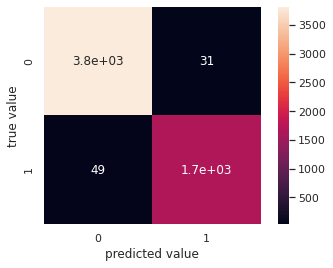

In [109]:
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, cbar=True)

plt.xlabel('predicted value')
plt.ylabel('true value');

**Marginal Table**

This marginal table collects four important criteria to examine.  This includes target (the true value of fatality rate), score (the score given by the classifier), prediction (the prediction of the classification of the fatality rate value), and gender (0 for male and 1 for female).

In [110]:
scores = model.predict_proba(X_test)[:, 1]
d = {'target' : y_test,
     'score' : scores,
     'prediction' : y_pred,
     'gender' : X_test[:, 0]
     }

"""
print(len(y_test))
print(len(scores))
print(len(y_pred))
print(len(X_test[:,0]))
"""

marginals = pd.DataFrame(data=d, columns=['target', 'score', 'prediction', 'gender'])
marginals.head(10)

,target,score,prediction,gender
0,0,0.00,0,0
1,1,0.76,1,1
2,0,0.00,0,1
3,0,0.00,0,1
4,0,0.00,0,1
5,1,1.00,1,0
6,0,0.04,0,0
7,1,0.75,1,0
8,1,0.88,1,0
9,0,0.00,0,0


# **Classification Analysis of Gender**



## **Independence**

In [111]:
# looked at 'UCI adult data set final.ipynb'
# P{prediction = 1, male} = P{prediction = 1, female}
# P{prediction = 1, male} / P{prediction = 1, female} >= 1 - epsilon(.2)

male_independence = marginals[marginals['gender'] == '0']
female_independence = marginals[marginals['gender'] == '1']

male_positive = len(male_independence[(male_independence['prediction'] == 1)])
female_positive = len(female_independence[(female_independence['prediction'] == 1)])

print("Number of male positives: ", male_positive)
print("Number of female positives: ", female_positive)

demographic_parity = male_positive / female_positive

print("Demographic Parity: " , demographic_parity)


Number of male positives:  1394
Number of female positives:  305
Demographic Parity:  4.5704918032786885


As we can see there is a large disparity in terms of male vs. female demographics.  But this could be due to the high number of male suicides compared to the female suicides.

## **Separation**

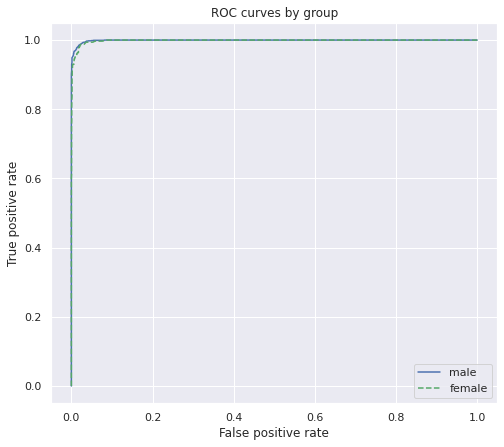

In [112]:
#the metrics.roc_curve method from sklearn library takes the labels, and scores 
# and reutrn false positive, true positive rate and a threshold which we ignore

male = marginals[marginals['gender'] == '0'] 
fpr_male, tpr_male, t_ = metrics.roc_curve(male['target'], male['score'])

female = marginals[marginals['gender'] == '1']
fpr_female, tpr_female, _ = metrics.roc_curve(female['target'], female['score'])

plt.figure(1, figsize=(8, 7))
plt.title('ROC curves by group')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.plot(fpr_male, tpr_male, label='male', linestyle='-', color='b')
plt.plot(fpr_female, tpr_female, label='female', linestyle='--', color='g')
plt.margins(x=0.05, y=0.05)

plt.legend()
plt.show()

The ROC curve shows the classification is very accurate in terms of the different groups (male and female).  This could be seen by low false positive rates in both populations in the confusion matrix.

## **Sufficiency**


In [0]:
# From UCI adult data set.ipynb

def score_range(p, q, df):
    """Returns number of success and observations for given bucket."""
    gp = df[df['score'] > p]
    lq = gp[gp['score'] <= q]
    return [sum(lq['target']), len(lq['target'])]

def get_frequencies(marginals, num_buckets=10):
    """Returns list of lists. The first list is successes 
    for all buckets, the second one is total counts."""
    ts = np.linspace(0, 1, num_buckets+1)
    frequencies = [[],[]]
    for i in range(num_buckets):
        b = score_range(ts[i], ts[i+1], marginals)
        frequencies[0].append(b[0])
        frequencies[1].append(b[1])
    return frequencies

def plot_confidence(plt, xs, n_succs, n_obss, label, linestyle, color, confidence=0.95):
    """Plot a graph with confidence intervals where
       each x corresponds to a binomial random variable in which n_obs observations led to n_succ successes"""
    n_succs, n_obss = np.array(n_succs), np.array(n_obss)
    conf_lbs, conf_ubs = proportion.proportion_confint(n_succs, n_obss, alpha=1-confidence)
    pylab.fill_between(xs, conf_ubs, conf_lbs, alpha=.2, color=color)
    pylab.plot(xs, n_succs / n_obss, '.-', label=label, linestyle=linestyle, color=color)

In [0]:
genders = ['0', '1']
styles = ['-', '--']
colors = ['r', 'b']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

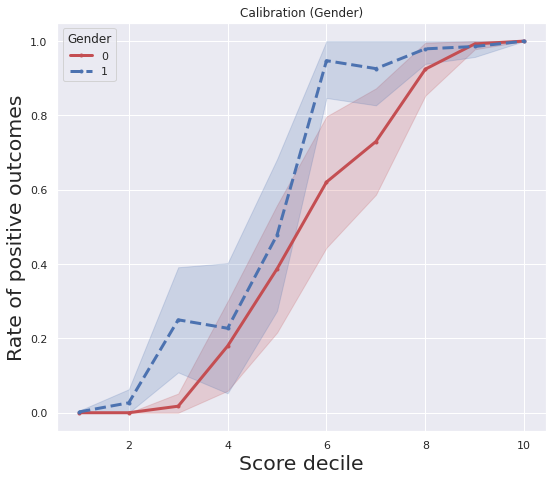

In [115]:
pylab.figure(2, figsize=(8, 7))
pylab.title('Calibration (Gender)')

for i in range(2):
    gender = genders[i]
    num = get_frequencies(marginals[marginals['gender']== gender])
    plot_confidence(plt, deciles, num[0], num[1], gender, styles[i], colors[i])

pylab.legend(title="Gender")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
pylab.tight_layout()

When referencing the Calibration plot above, it is apparent that the female population has a higher rate of positive outcomes for almost all score deciles. 

The large error field (shaded region) for female population could be attributed to the data scarcity of the female population because the male population has a greater number of suicides.

**Confusion Matrix for Male & Female**

In [116]:
male = marginals[marginals['gender'] == '0']

male_true_positive = len(male[(male['target'] == 1) & (male['prediction'] == 1)]) / len(male)
male_false_positive = len(male[(male['target'] == 0) & (male['prediction'] == 1)]) / len(male)

male_true_negative = len(male[(male['target'] == 0) & (male['prediction'] == 0)]) / len(male)
male_false_negative = len(male[(male['target'] == 1) & (male['prediction'] == 0)]) / len(male)


male_table = pd.DataFrame({'true': [male_true_positive, male_true_negative],
                           'false' : [male_false_positive, male_false_negative]}, index=['positive', 'negative'])

male_table

,true,false
positive,0.505543,0.009608
negative,0.477458,0.007391


In [117]:
female = marginals[marginals['gender'] == '1']

female_true_positive = len(female[(female['target'] == 1) & (female['prediction'] == 1)]) / len(female)
female_false_positive = len(female[(female['target'] == 0) & (female['prediction'] == 1)]) / len(female)

female_true_negative = len(female[(female['target'] == 0) & (female['prediction'] == 0)]) / len(female)
female_false_negative = len(female[(female['target'] == 1) & (female['prediction'] == 0)]) / len(female)


female_table = pd.DataFrame({'true': [female_true_positive, female_true_negative],
                             'false' : [female_false_positive, female_false_negative]}, index=['positive', 'negative'])

female_table

,true,false
positive,0.104969,0.001749
negative,0.883135,0.010147


As we can see in the confusion matrices above, male has a much more balanced true-positive and true-negative rate compared to the female population.  It is also apparent that both populations have low (> 1%) false-positive and false-negativve rates.

**Positive Predictive Parity (PPV = TP / TP+FP)**

In [118]:
male_ppv = male_true_positive / (male_true_positive + male_false_positive)
print("Male Positive Predictive Parity: ", male_ppv)

female_ppv = female_true_positive / (female_true_positive + female_false_positive)
print("Female Positive Predictive Parity: ", female_ppv)


Male Positive Predictive Parity:  0.9813486370157819
Female Positive Predictive Parity:  0.9836065573770493


**Negative Predictive Parity (NPV = TN / TN+FN)**

In [119]:
male_npv = male_true_negative / (male_true_negative + male_false_negative)
print("Male Negative Predictive Parity: ", male_npv)

female_npv = female_true_negative / (female_true_negative + female_false_negative)
print("Female Negative Predictive Parity: ", female_npv)

Male Negative Predictive Parity:  0.9847560975609756
Female Negative Predictive Parity:  0.9886408147277713


Both the positive predictive parity and negative predictive parity rates are similar for the male and female populations.  This shows that the classification is fair in terms of predictive parity.